In [2]:
from core import *
import utils
import time as time
from pathlib import Path
import numpy as np

pH (HH) [5.74]
count value: 0
Acid/Base ratio measured: [0.1]
Optimization restart 1/5, f = 3.1663977458035943
Optimization restart 2/5, f = 3.1663977442723543
Optimization restart 3/5, f = 3.1663978211934496
Optimization restart 4/5, f = 3.166397748168218
Optimization restart 5/5, f = 3.1663977710443154
The next ratio to investigate is [7.20769231]


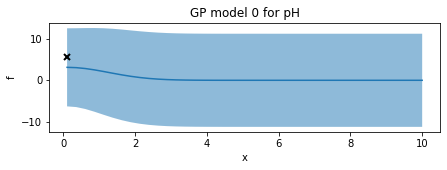

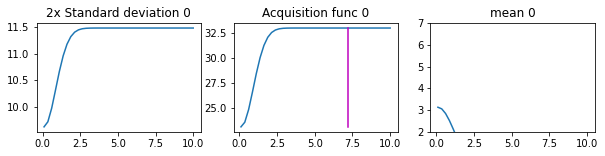

pH (HH) [3.88220376]
counter value: 1
Acid/Base ratio measured: [7.20769231]
Optimization restart 1/5, f = 6.016328861259485
Optimization restart 2/5, f = 6.016328862590455
Optimization restart 3/5, f = 6.016328861955042
Optimization restart 4/5, f = 6.016328866717329
Optimization restart 5/5, f = 6.016328860284641
The next ratio to investigate is [3.4]


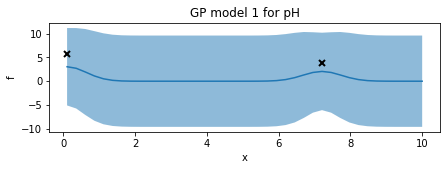

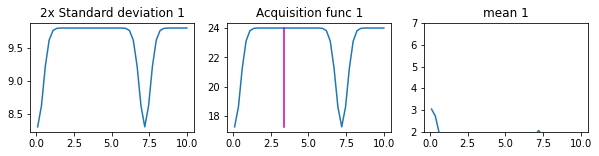

pH (HH) [4.20852108]
counter value: 2
Acid/Base ratio measured: [3.4]
Optimization restart 1/5, f = 6.0648332278824455
Optimization restart 2/5, f = 6.064833227872112
Optimization restart 3/5, f = 8.887247577228294
Optimization restart 4/5, f = 6.0648332335988275
Optimization restart 5/5, f = 6.064833227966798
The next ratio to investigate is [10.]


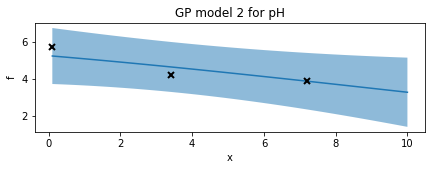

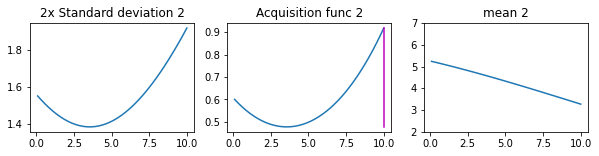

pH (HH) [3.74]
counter value: 3
Acid/Base ratio measured: [10.]
Optimization restart 1/5, f = 6.966296827460687
Optimization restart 2/5, f = 11.660165150482978
Optimization restart 3/5, f = 6.96629682317457
Optimization restart 4/5, f = 6.966296823103098
Optimization restart 5/5, f = 6.966296823060338
The next ratio to investigate is [0.35384615]


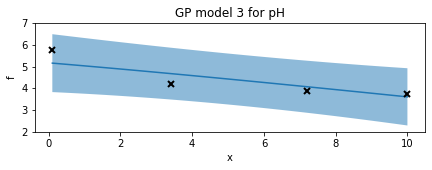

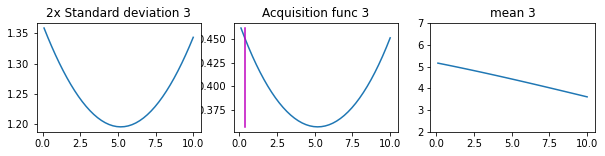

pH (HH) [5.19118552]
counter value: 4
Acid/Base ratio measured: [0.35384615]
Optimization restart 1/5, f = 7.377957835608671
Optimization restart 2/5, f = 7.377957796164652
Optimization restart 3/5, f = 7.377957796251334
Optimization restart 4/5, f = 7.377957797835975
Optimization restart 5/5, f = 7.377957796113796
The next ratio to investigate is [9.74615385]


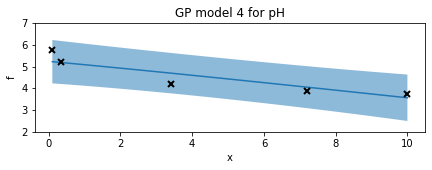

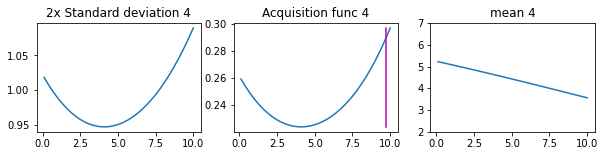

pH (HH) [3.75116674]
counter value: 5
Acid/Base ratio measured: [9.74615385]


In [3]:
#After speaking with Gilad, this Jupyter cell was cleaned up for GP exploration
#Plotting to a file was added. All images are in subdir ./plots

import GPy

def Bayesian_exploration_pH():
    # Uses GPy for Gaussian Process regression as surrogate function.

    # Set up file
    filename1="./plots/foo_measurements.txt"  #contains acid-base ratio and pH measurements
    f1=open(filename1,"w")
    f1.write("count     ratio      pH\n")
    
    # X_grid is the list of all possible acid-base ratios that can be investigated.
    # This is the array that will be indexed with next_sample_index
    X_grid = np.linspace(0.1,10,40)[:,None]  #no. pts has to be greater than loop iterations
    #Dsize = X_grid.shape # X_grid has number rows x 1 column
    #print(f'x grid: {X_grid}, Dsize : {Dsize}')   

    # set up variables
    ratio = [.1] # acid-base ratio of initial sample to study, 0 is no acid
    sample_index = 0 # index of ratio in list of ratios
    count = 0 #counter for moving to appropriate well

    # deposit first ratio in well and collect pH
    pH = BO_get_data(ratio,count) 
    print('count value:',count)
    print('Acid/Base ratio measured:',ratio)
    #print('pH Value:',pH)
    f1.write("%5d, %8.2f, %8.2f\n" % (count, ratio[0], pH) )
    
    measured = np.atleast_1d(sample_index) # indices of ratios that have been measured
    full_indices = np.linspace(0, X_grid.shape[0]-1, X_grid.shape[0]) # indices of all ratios to be investigated
    unmeasured = np.setdiff1d(full_indices, measured).astype(int)  # indices of ratios that are still to be measured
    X_samples = np.atleast_1d(ratio)[:,None] # X_samples is the acid-base ratios already studied
    Y_samples = np.atleast_1d(pH)[:,None] # Y_samples are the corresponding pH for the measured ratios.
    
    # iteration loop for active learning (GP with exploration)
    for iterations in range(5):

        # Regression. Amplitude and length are built into RBF. GP fits to (or learns from) data.
        k = GPy.kern.RBF(1)      
        m = GPy.models.GPRegression(X_samples, Y_samples, k)
        
        #blockPrint() # blocks printing statements to avoid printing GPy's optimization statements.
        m.optimize_restarts(5, robust=True);
        #try 5 different GP runs and initialize each differently. Take best result.
        #enablePrint() # restarts the internal printing statements
        
        mean_full, variance_full = m.predict(X_grid, full_cov = False) # Prediction. full_cov default if False?
        mean, variance = m.predict(X_grid[unmeasured]) # Prediction just for unmeasured ratios
        #print('Variance_full is\n', variance_full)
        
        # Active Learning by exploration
        alpha_full = variance_full # variance for all ratios. Use variance (uncertainty) in Gaussian Process
                                   # to guide next sample
        alpha = variance # variance for unmeasured ratios
        sample_index = unmeasured[ np.argmax(alpha) ] # index of next ratio in X_grid
        ratio = X_grid[sample_index,:] # next ratio which is a one-element array
        
        print('The next ratio to investigate is', ratio)

        # plot GP variance for all ratios
        plt.figure(figsize=(7,2))
        if iterations>=3:
            plt.ylim(2,7)  #Can set y-axis limits
        plot_gp(X_grid, mean_full, variance_full, iterations, training_points=(X_samples,Y_samples))
               
        # plot
        num_subplots = 3
        
        plt.figure(figsize = (10,2))
        plt.subplot(1,num_subplots,2)
        plt.plot(X_grid, alpha_full)  # plot the acquisition function for all ratios
        plt.plot([ratio, ratio],[np.min(alpha_full), np.max(alpha_full)],'m') # indicate the next ratio to be investigated
        plt.title(f'Acquisition func {iterations}')
               
        plt.subplot(1,num_subplots,1)
        plt.plot(X_grid, 2*np.sqrt(alpha_full))
        plt.title(f'2x Standard deviation {iterations}')
        
        plt.subplot(1,num_subplots,3)
        plt.plot(X_grid, mean_full, "-")  # ???Plot GP mean. How to find max, min of GP to fix vert axes
        plt.title(f'mean {iterations}')
        plt.ylim(2, 7)
        plt.savefig(f"./plots/foosubplots {iterations}.png", facecolor='white')
        plt.show()
                
        #plt.close()
           
        count+=1           #move to next well
        
        # collect data
        pH = BO_get_data(ratio, count) # run the next experiment
        print('counter value:',count)
        print('Acid/Base ratio measured:',ratio)
        #print('pH Value:',pH)
        f1.write("%5d, %8.2f, %8.2f\n" % (count, ratio[0], pH) )
        
        measured = np.append(measured, sample_index) # add experiment ratio to the set of measured
        unmeasured = np.setdiff1d(full_indices, measured).astype(int)
        X_samples = np.append(X_samples, ratio)[:,None]
        Y_samples = np.append(Y_samples, pH)[:,None]
    
    f1.close()
    
    return m
    
def BO_get_data(ratio, count):   #modified to generate fake data

    acid_vol,base_vol = ratio_conversion(ratio)
    #print('acid_vol, base_vol:', acid_vol, base_vol)
   
    pH = 4.74 - np.log10(ratio)
    print(f"pH (HH) {pH}")  
    return pH

def ratio_conversion(ratio):
    acid_vol = float(2.0*ratio[0]/(1+ratio[0]))
    base_vol = float(2.0 - acid_vol)
    return acid_vol,base_vol          
    
def plot_gp(X, m, C, iterations, training_points=None):   #C is covariance, 1D ndarray
    # Plot results of Gaussian Process analysis.
    # Plot 95% confidence interval, alpha is opacity
    ##plt.fill_between(X[:,0], m[:,0] - 1.96*np.sqrt(np.diag(C)), m[:,0] + 1.96*np.sqrt(np.diag(C)), alpha=0.5)
    plt.fill_between(X[:,0], m[:,0] - 1.96*np.sqrt(C[:,0]), m[:,0] + 1.96*np.sqrt(C[:,0]), alpha=0.5)
    
    #plt.title('GP model for pH')
    plt.title(f"GP model {iterations} for pH")
    plt.plot(X, m, "-")  # Plot GP mean 
    plt.xlabel("x"), plt.ylabel("f")
       
    if training_points is not None:  # Plot training points if included
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.savefig(f"./plots/foo{iterations}.png", facecolor='white')
        plt.show()
    

m = Bayesian_exploration_pH()

In [ ]:
#Goals
#Exploration is surrogate model regression (non-parametric model regression)
#Bayesian inference: we know a set of models but want to determine which model is best
#Could build a symbolic regression tool where we don't know the model equation but want to
#find/fit a model, then output the equation. Harder method.

In [3]:
#Surrogate model regression results in ability to interpolate to predict value of mean and variance
#at an unmeasured x.
mean, variance = m.predict(np.atleast_1d([1.2])[:,None]) # Prediction just for unmeasured ratios
print('mean,variance:', mean, variance)
print(m)
#over a range of 2 in x, there would be a change in y of Sqrt[55] (roughly)

mean,variance: [[5.19485318]] [[0.14256871]]

Name : GP regression
Objective : 6.664925873054421
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    29.10909092996704  |      +ve      |        
  rbf.lengthscale          |    33.22963455698687  |      +ve      |        
  Gaussian_noise.variance  |  0.10375008008933781  |      +ve      |        


In [ ]:
# RAW NOTES from meeting with Gilad on 7/5/24
#https://www.ni.com/docs/en-US/bundle/labview-api-ref/page/vi-lib/analysis/6fits-llb/gaussian-peak-fit-vi.html

import GPy
#path = 'c:\Users\grufi\OneDrive\Desktop\legolas\Legolas_textCellLoc-main\plots'
#SAVE = Path(path)
#SAVE.mkdir(exist_ok=True)

def Bayesian_optimization_pH():
    # Uses GPy for Gaussian Process regression as surrogate function.

    # If True, this will simulate deposition and measurement
    simulate_val = True                   ##delete this
    
    # X_grid is the list of all possible acid-base ratios that can be investigated.
    # This is the array that will be indexed with next_sample_index
    ##X_grid = np.linspace(0.1,1,20)[:,None]
    ##other = np.linspace(2,10,20)[:,None]
    ##X_grid = np.append(X_grid,other)[:,None] # set of all acid and base ratios, column matrix
    X_grid = np.linspace(0.1,10,40)[:,None]  #no. pts has to be greater than loop iterations
    #Dsize = X_grid.shape[0] # number in X_grid set
    #print(f'x grid: {X_grid}, Dsize : {Dsize}')
    BO_lambda = .1              #???not used for exploration
    #BO_lambda is fr upper confidence bound
    
    # # set up GP.              #???start with initial x=1., y=210. 14th sample, 15 samples
    #unmeasured is 0-13
    # X_samples = np.atleast_1d([1.])[:,None] # ratio of R to G
    # Y_samples = np.atleast_1d([210.])[:,None]
    # measured = np.asarray([14])
    # unmeasured = np.setdiff1d(np.linspace(0,14,15), measured).astype(int)
    
    # set up variables
    ratio = [.1] # acid-base ratio of initial sample to study, 0 is no acid
    sample_index = 0 # index of ratio in list of ratios
    count = 0 #counter for moving to appropriate well

    # deposit first ratio in well and collect pH
    pH = BO_get_data(ratio,count) 
    print('count value:',count)
    print('Acid/Base ratio measured:',ratio)
    #print('pH Value:',pH)
    
    measured = np.atleast_1d(sample_index) # indices of ratios that have been measured
    full_indices = np.linspace(0, X_grid.shape[0]-1, X_grid.shape[0]) # indices of all ratios to be investigated
    unmeasured = np.setdiff1d(full_indices, measured).astype(int)  # indices of ratios that are still to be measured
    X_samples = np.atleast_1d(ratio)[:,None] # X_samples is the acid-base ratios already studied
    Y_samples = np.atleast_1d(pH)[:,None] # Y_samples are the corresponding pH for the measured ratios.
    
    # iteration loop for active learning (GP with exploration CO)
    for iterations in range(5):

        # Regression
        k = GPy.kern.RBF(1)
        #amplitude and length built into RBF. GP learns (or fits) to data.
        m = GPy.models.GPRegression(X_samples, Y_samples, k)
        #blockPrint() # blocks printing statements to avoid printing GPy's optimization statements.
        m.optimize_restarts(5, robust=True);                #???what is this doing?
        #try 5 different GP runs and initialize each differently. Take best result
        #enablePrint() # restarts the internal printing statements
        mean_full, variance_full = m.predict(X_grid, full_cov = False) # Prediction. full_cov default???
        #print('Variance_full is\n', variance_full)
        mean, variance = m.predict(X_grid[unmeasured]) # Prediction just for unmeasured ratios
        
        # # Bayesian optimization to maximize measured red by varying mixture.
        # BO_beta = 2 * math.log(Dsize * math.pow(iterations + 1,2) * math.pow(np.pi,2) / (6 * BO_lambda) )
        # above is upper confidence bound. Active learning to optimize
        # alpha = -1 * np.abs(100. - mean) + math.sqrt(BO_beta) * variance
        
        # Active Learning by exploration
        alpha_full = variance_full # variance for all ratios. Use variance (uncertainty) in Gaussian Process
                                   # to guide next sample
        alpha = variance # variance for unmeasured ratios
        ##alpha = (9/(iterations+1))*variance - np.absolute(mean-4.75)
        ##alpha_full = (9/(iterations+1))*variance_full - np.absolute(mean_full-4.75)
        sample_index = unmeasured[ np.argmax(alpha) ] # index of next ratio in X_grid
        ratio = X_grid[sample_index,:] # next ratio
        print('The next ratio to investigate is', ratio)

        # plot GP variance for all ratios
        plt.figure(figsize=(7,2))
        plot_gp(X_grid, mean_full, variance_full, training_points=(X_samples,Y_samples)) 
        
        # plot
        num_subplots = 3
        ##if ~simulate_val:        #~complements the bits, so ~True=11111110. Nonzero so treated as true
        ##    num_subplots = 3
        
        plt.figure(figsize = (10,2))
        plt.subplot(1,num_subplots,2)
        plt.plot(X_grid, alpha_full)  # plot the acquisition function for all ratios
        plt.plot([ratio, ratio],[np.min(alpha_full), np.max(alpha_full)],'m') # indicate the next ratio to be investigated
        plt.title(f'Acquisition func')
        #plt.tight_layout()
        #plt.savefig(SAVE/f"Acquisition{iterations}.png", facecolor='white')
        #plt.show()   
               
        plt.subplot(1,num_subplots,1)
        plt.plot(X_grid, 2*np.sqrt(alpha_full))
        plt.title(f'2x Standard deviation')
        #plt.show() 
        
        plt.subplot(1,num_subplots,3)
        plt.plot(X_grid, mean_full, "-")  # ???Plot GP mean. How to find max, min of GP to fix vert axes
        plt.title(f'mean')
        plt.show()
        #plt.close()
           
        count+=1           #move to next well
        
        # collect data
        pH = BO_get_data(ratio, count) # run the next experiment
        print('counter value:',count)
        print('Acid/Base ratio measured:',ratio)
        #print('pH Value:',pH)
        measured = np.append(measured, sample_index) # add experiment ratio to the set of measured
        unmeasured = np.setdiff1d(full_indices, measured).astype(int)
        X_samples = np.append(X_samples, ratio)[:,None]
        Y_samples = np.append(Y_samples, pH)[:,None]
       
    return m
    
def BO_get_data(ratio, count):   #modified to generate fake data

    acid_vol,base_vol = ratio_conversion(ratio)
    #print('acid_vol, base_vol:', acid_vol, base_vol)
   
    pH = 4.74 - np.log10(ratio)
    print(f"pH (HH) {pH}")  
    return pH

def ratio_conversion(ratio):
    acid_vol = float(2.0*ratio[0]/(1+ratio[0]))
    base_vol = float(2.0 - acid_vol)
    return acid_vol,base_vol          
    
def plot_gp(X, m, C, training_points=None):   #C is covariance, 1D ndarray
    # Plot results of Gaussian Process analysis.
    # Plot 95% confidence interval, alpha is opacity
    ##plt.fill_between(X[:,0], m[:,0] - 1.96*np.sqrt(np.diag(C)), m[:,0] + 1.96*np.sqrt(np.diag(C)), alpha=0.5)
    plt.fill_between(X[:,0], m[:,0] - 1.96*np.sqrt(C[:,0]), m[:,0] + 1.96*np.sqrt(C[:,0]), alpha=0.5)
    
    plt.title('GP model for pH')
    plt.plot(X, m, "-")  # Plot GP mean 
    plt.xlabel("x"), plt.ylabel("f")
    #plt.savefig(SAVE/f"gp{iterations}.png", facecolor='white')
    if training_points is not None:  # Plot training points if included
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.show()

m = Bayesian_optimization_pH()

In [ ]:
C=np.array([[1],[2],[3]])
#C=np.array([1, 2, 3])
print(C)
print('np.diag(C):', np.diag(C))

In [ ]:
f1.close()
